### Case Study - Pinchout and Fault Scenarios
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases how structural parameters, in this case CPz and fault_offset can be used to generate multiple structural models and address structural uncertainty in 3D groundwater models. This notebook contains the Pinchout and Fault Scenarios and use a synthetic example to explore uncertainty in pinchout location and fault geometry. 

In [6]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [7]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# Spatial information
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [] 
P.npump = len(P.xypumpbores)
P.idpumpbores = [] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500)]
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]
#P.geo_bores = ['P1', 'P2', 'P3', 'P4']

# Observation Points
P.nobs = len(P.xyobsbores)
obs_z = [-40, -50, -100, -200, -300]
P.nzobs = len(obs_z)
P.zobs = np.ones((P.nobs, P.nzobs))
for j in range(P.nzobs):
    P.zobs[:, j] = P.zobs[:, j] * obs_z[j] 

# Meshing parameters
P.triExeName = '../exe/triangle.exe'
P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 3000, 1000) # fault end points
P.fault_buffer = 150.  # offset boundary from fault
P.r = 40               # refining factor for model boundary. High r has refined edges
P.w = 150              # interior boundary offset
P.boundmaxtri = 50000  # max triangle area in boundary area
P.modelmaxtri = 50000  # max triangle area in main model area
P.angle = 32           # minimum triangle angles
P.radius1 = 100        # radius of inner circle around pumping bores
P.radius2 = 200        # radius of outer circle around pumping bores
P.boremaxtri = 100000   # max triangle area within bore radius

# Flow model parameters
P.mfexe_name = '../exe/mf6.exe'
P.workspace = '../modelfiles/'
P.nlg = 4    # number of geological layers
P.nls = 3    # number sublayers for conformable
P.nlv  = 30  # number of layers for voxel transect grid

P.ss = [0.00001, 0.00001, 0.00001, 0.00001]
P.sy = [0.1, 0.1, 0.1, 0.1]
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
if not os.path.isdir('../modelfiles'):
    os.makedirs(P.workspace, exist_ok=True)

In [8]:
P.cell2dtri, P.xcyctri, P.verticestri, P.tri, trinodes = createcell2d(P, grid = 'tri', fault = True)  
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  

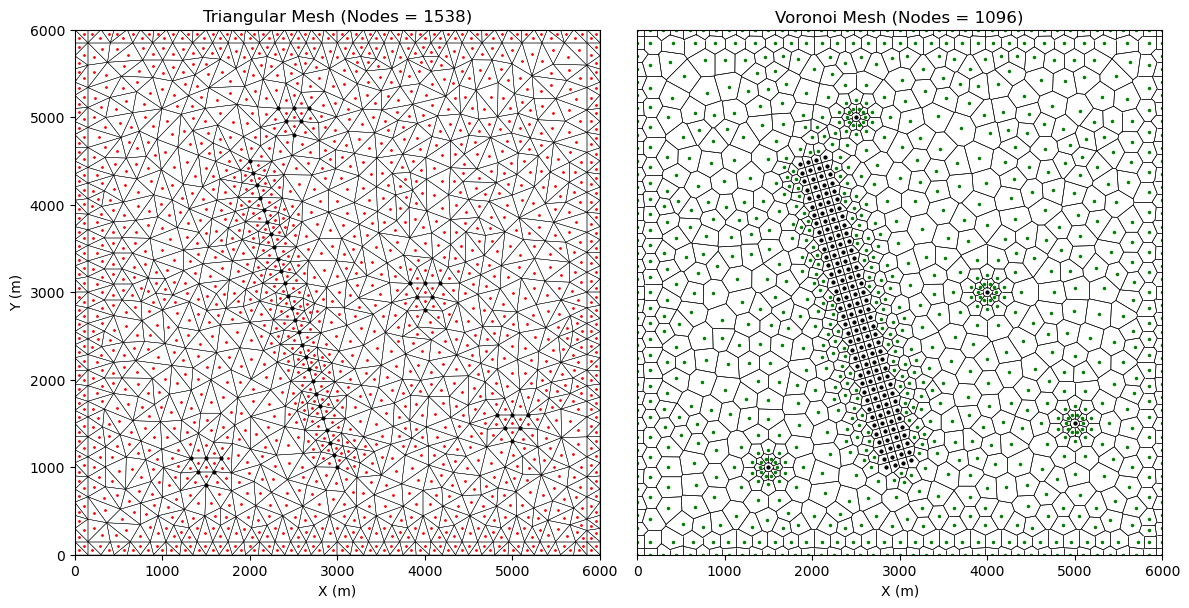

In [9]:
figure2(P)

### Faults - 6 simulations

In [10]:
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = np.linspace(0, 320, 6) # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
    
fault_modelnames, fault_models, fault_obs_heads = [],[],[]         

for i in range(len(options)):
    fault_modelnames.append(str('FD_'+str(options[i])))  
    fault_models.append(Model(fault_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.fault_max_disp = options[i] /2
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    M = fault_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    fault_obs_heads.append((process_obs_steady(P, M)))
    f = os.path.join(vtk_workspace, "faults", M.modelname)
    M.gwf.export(f, fmt="vtk")

                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD_0.0  ...
   Creating property arrays for  FD_0.0  ...
   Adding flow packages to  FD_0.0  ...
   Time taken =  1.510051
   Writing simulation and gwf for  FD_0.0  ...
Period =  Steady 
   Model success =  True
   run_time =  26.723291


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD_64.0  ...
   Creating property arrays for  FD_64.0  ...
   Adding flow packages to  FD_64.0  ...
   Time taken =  0.94997
   Writing simulation and gwf for  FD_64.0  ...
Period =  Steady 
   Model success =  False
   Re-writing IMS - Take 2
Model success2 =  False
   Re-writing IMS - Take 3
Model success3 =  False


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# PLOTS
#plot_bores(P)
#plot_observations(heads = fault_obs_heads, modelnames = fault_modelnames, ylim = [-40, -5])
#plot_bylayer(P, models = fault_models, layer = 2, vmin = -35, vmax = -10) 
#multiplot_vgrid_transect(P, models = fault_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
#multiplot_prop_transect(P, models = fault_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

In [ ]:
%run ./loop_showcase_functions.ipynb
figure5(P, models = fault_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,vmin = -45, vmax = -5)

### Pinchout - 6 simulations

In [ ]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

options = np.linspace(-250, 0, 6) # control point z values

pinchout_modelnames, pinchout_models, pinchout_obs_heads = [],[],[]        
heads = []

for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    pinchout_obs_heads.append((process_obs_steady(P, M)))
    heads.append((M.head_ss))
    f = os.path.join(vtk_workspace, "pinchouts", M.modelname)
    M.gwf.export(f, fmt="vtk")
    


In [ ]:
#plot_bylayer(P, models = pinchout_models, layer = 1, vmin = -40, vmax = 20) 
#plot_observations(ylim = [-40, 20], modelnames = pinchout_modelnames, heads = pinchout_obs_heads)
#multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)
#multiplot_prop_transect(P, models = pinchout_models, array = 'head_ss', 
                        #X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 10)

In [ ]:
%run ./loop_showcase_functions.ipynb
figure4(P, models = pinchout_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

### Pinchout - 100 simulations

In [ ]:
options = np.linspace(-250, 0, 100) # control point z values
    
heads_PO = []
for i in range(len(options)): 
    M = Model('PO', P, plan = 'vor', transect = 'con') # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    heads_PO.append((M.head_ss))


In [ ]:
layer = 2

stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(M.idomain, dtype=float) 
    for i, h in enumerate(heads_PO[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[M.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
var_PO = np.var(np.array(stacked), axis = 0)

### Fault - 100 realisations

In [ ]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = np.linspace(0, 320, 100) # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
        
heads_FD = []
for i in range(len(options)):

    N = Model('FD', P, plan = 'vor', transect = 'con') # Create flow model  
    P.fault_max_disp = options[i] /2
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    N.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    N.create_prop_arrays(P)                                     # Create K arrays
    N.create_flow_package_arrays(P)                             # Create flow packages
    N.gwf, N.head_ss, N.obs_ss, N.runtime_ss = N.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    heads_FD.append(N.head_ss)


In [ ]:
# FAULT
stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(N.idomain, dtype=float) 
    for i, h in enumerate(heads_FD[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[N.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
var_FD = np.var(np.array(stacked), axis = 0)

In [ ]:
def figure6(P, var_PO, var_FD):
    
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Variance in head due to alternative structural models')
    ax = plt.subplot(1, 2, 1, aspect='equal')
    #P.vor.plot(ax=ax, edgecolor='black', lw = 0.2)
    pmv = flopy.plot.PlotMapView(model=M.gwf)
    pmv.plot_grid(edgecolor='black', lw = 0.2)
    A = pmv.plot_array(var_PO, cmap = 'Spectral', alpha = 0.6)#vmin = vmin, vmax = vmax, 
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Pinchout Scenario')
    plt.colorbar(A, ax=ax, shrink = 0.4)
    
    ax = plt.subplot(1, 2, 2, aspect='equal')
    #P.vor.plot(ax=ax, edgecolor='black', lw = 0.2)
    grid = N.gwf.modelgrid
    pmv = flopy.plot.PlotMapView(model=N.gwf)
    pmv.plot_grid(edgecolor='black', lw = 0.2)
    B = pmv.plot_array(var_FD, cmap = 'Spectral', alpha = 0.6)#vmin = vmin, vmax = vmax, 
    
    ax.set_xlabel('X (m)')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title('Fault Scenario')
    plt.colorbar(B, ax=ax, shrink = 0.4)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.1)    
    plt.tight_layout()  
    plt.show()   
    fig.savefig('../figures/fig6.tif', dpi=300)

figure6(P, var_PO, var_FD)